<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Выгрузка-данных-и-ресемплирование" data-toc-modified-id="Выгрузка-данных-и-ресемплирование-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выгрузка данных и ресемплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее--и-распределение-по-отрезкам-времени" data-toc-modified-id="Скользящее-среднее--и-распределение-по-отрезкам-времени-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящее среднее  и распределение по отрезкам времени</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Признаки-лагов" data-toc-modified-id="Признаки-лагов-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Признаки лагов</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Catboost_model" data-toc-modified-id="Catboost_model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Catboost_model</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Random-Forrest" data-toc-modified-id="Random-Forrest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random Forrest</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install numpy -q
!pip install lightgbm -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Константы
RANDOM_STATE = 42
TEST_SIZE = 0.1

### Выгрузка данных и ресемплирование

In [4]:
# функция вывода информации о данных
def data_info(data):
    display(data.head(20))
    data.info()
    display(data.describe())

In [5]:
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col = 'datetime')

In [6]:
data_info(taxi)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
taxi= taxi.sort_index(ascending=True)

In [8]:
taxi.index.is_monotonic

True

In [9]:
taxi = taxi.resample('1H').sum() 

<AxesSubplot:xlabel='datetime'>

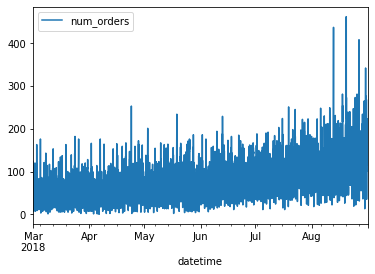

In [10]:
taxi.plot()

## Анализ

### Скользящее среднее  и распределение по отрезкам времени

In [11]:
taxi['rolling_mean'] = taxi.rolling(100, min_periods=2).mean()

<AxesSubplot:xlabel='datetime'>

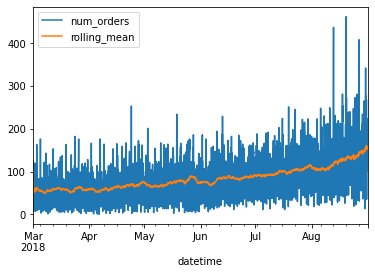

In [12]:
taxi.plot()

In [13]:
taxi['day'] = taxi.index.day
taxi['day_of_week'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour

<AxesSubplot:xlabel='day'>

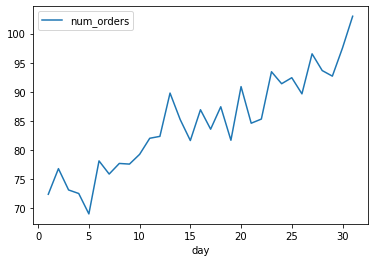

In [14]:
pd.pivot_table(taxi, values='num_orders', index='day', aggfunc='mean').plot()

Ближе к концу месяца заказов больше

<AxesSubplot:xlabel='day_of_week'>

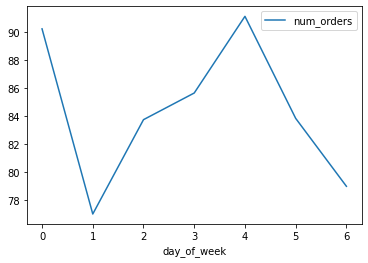

In [15]:
pd.pivot_table(taxi, values='num_orders', index='day_of_week', aggfunc='mean').plot()

Обнаружен пик активности заказов в пятницу (что логично -гости, мероприятия - чаще пользуешься такси) и в понедельник. <br>  

<AxesSubplot:xlabel='hour'>

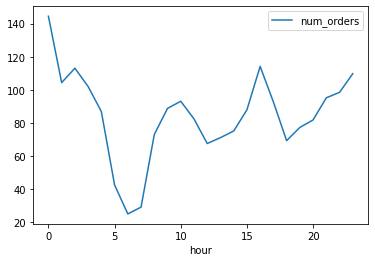

In [16]:
pd.pivot_table(taxi, values='num_orders', index='hour', aggfunc='mean').plot()

Видим пик активности в районе 16-17 часов, а также 23-00

### Тренды и сезонность

In [17]:
decomposed = seasonal_decompose(taxi['num_orders'])

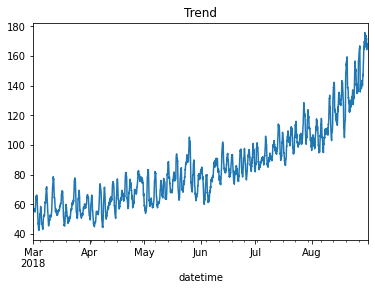

In [18]:
decomposed.trend.plot()
plt.title('Trend')
plt.show()

Наблюдается восходящий тренд  с ускорением к лету

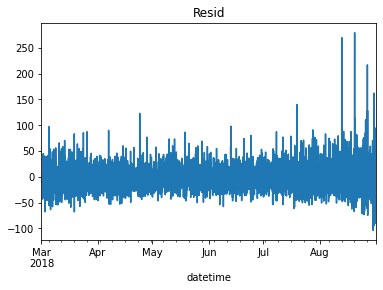

In [19]:
decomposed.resid.plot()
plt.title('Resid')
plt.show()

Остатки нестабильные, с увеличением к концу рассматриваемого периода <br> Доля остатков к концу периода больше

Рассмотрим временной ряд понедельно, поскольку плотность данных высока:

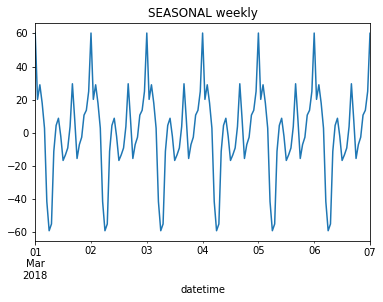

In [20]:
decomposed.seasonal.plot()
plt.title('SEASONAL weekly')
plt.xlim(('2018-03-01', '2018-03-07'))
plt.show()

Можно наблюдать зависимость от часа дня.

### Признаки лагов

Видим общий восходящий тренд и четкую посуточную сезонность. Примем количество лагов 24.

In [21]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

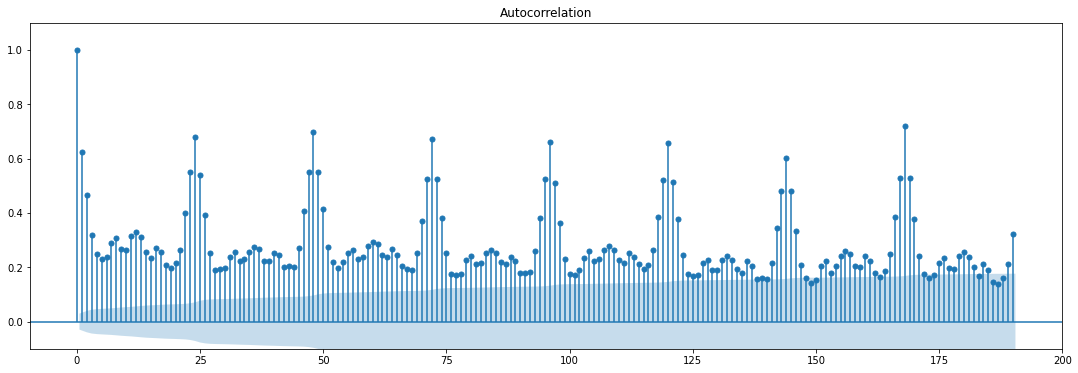

In [22]:
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

Также добавим 168 лаг по результатам автокорреляции

In [23]:
taxi_1 = make_features(taxi, 168, 10).dropna()

In [24]:
taxi = make_features(taxi, 24, 10).dropna()

In [25]:
lag_168 = taxi_1['lag_168']

In [26]:
taxi = pd.concat([taxi, lag_168], axis=1)

## Обучение

In [29]:
train, test = train_test_split(taxi, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()

y_train = train['num_orders']
X_train = train.drop('num_orders', axis=1)

y_test = test['num_orders']
X_test = test.drop('num_orders', axis=1)

Для анализа важности признаков добавим функцию importances

In [30]:
def importances(model,features):
    features=features.columns
    importances = model.best_estimator_.feature_importances_
    indexes = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность признака')
    plt.barh(range(len(indexes)), importances[indexes])
    plt.yticks(range(len(indexes)), features[indexes])
    plt.xlabel('Относительная важность')
    plt.show()

### Catboost_model

In [31]:
catboost_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
param_grid = {'learning_rate': [0.03, 0.1],
              'depth': [5, 10]
}

tscv = TimeSeriesSplit(n_splits=5)
gsearch_c = GridSearchCV(estimator=catboost_model, cv=tscv, param_grid=param_grid, scoring='neg_mean_squared_error')
gsearch_c.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f393da8b940>,
             param_grid={'depth': [5, 10], 'learning_rate': [0.03, 0.1]},
             scoring='neg_mean_squared_error')

In [32]:
RMSE_catboost = mean_squared_error(y_train, gsearch_c.predict(X_train)) ** 0.5

In [33]:
print('Catboost-RMSE', RMSE_catboost)

Catboost-RMSE 15.60058085585057


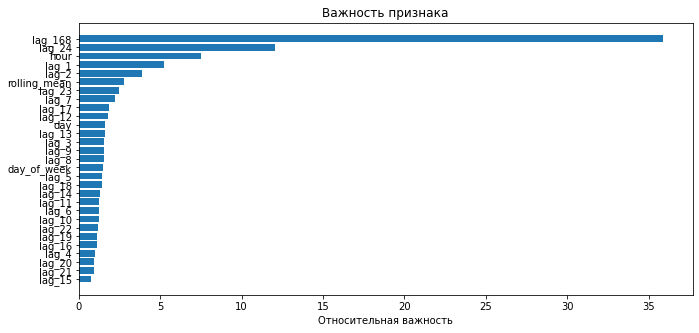

In [34]:
importances(gsearch_c, X_train)

### LightGBM

In [35]:
lgbm_model = LGBMRegressor(objective='root_mean_squared_error',
                           random_state=RANDOM_STATE,
                           verbose=-1)

In [36]:
param_grid = {
    'learning_rate': [0.1, 0.3, 1],  
    'max_depth': [1, 2, 6]
}

tscv = TimeSeriesSplit(n_splits=5)
gsearch_l = GridSearchCV(estimator=lgbm_model, cv=tscv, param_grid=param_grid, scoring='neg_mean_squared_error')
gsearch_l.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(objective='root_mean_squared_error',
                                     random_state=42, verbose=-1),
             param_grid={'learning_rate': [0.1, 0.3, 1],
                         'max_depth': [1, 2, 6]},
             scoring='neg_mean_squared_error')

In [37]:
RMSE_lgbm = mean_squared_error(y_train, gsearch_l.best_estimator_.predict(X_train)) ** 0.5

In [38]:
print('LightGBM-RMSE', RMSE_lgbm)

LightGBM-RMSE 20.21750583948393


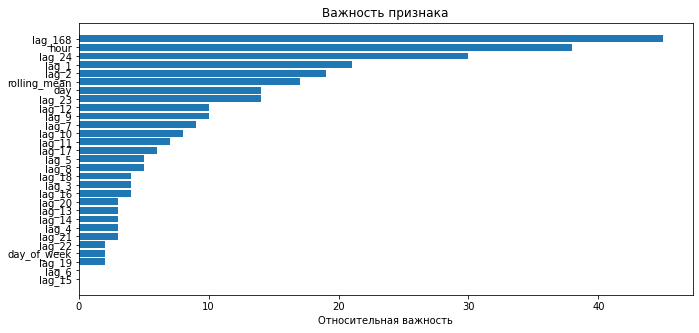

In [39]:
importances(gsearch_l, X_train)

### Random Forrest

In [40]:
forest_model = RandomForestRegressor()

forest_parameters = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }

tscv = TimeSeriesSplit(n_splits=5)
gsearch_f = GridSearchCV(estimator=forest_model, cv=tscv, param_grid=forest_parameters, scoring='neg_mean_squared_error')
gsearch_f.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring='neg_mean_squared_error')

In [41]:
RMSE_forrest = mean_squared_error(y_train, gsearch_f.best_estimator_.predict(X_train)) ** 0.5

In [42]:
print('Forrest-RMSE', RMSE_forrest)

Forrest-RMSE 13.092670322066366


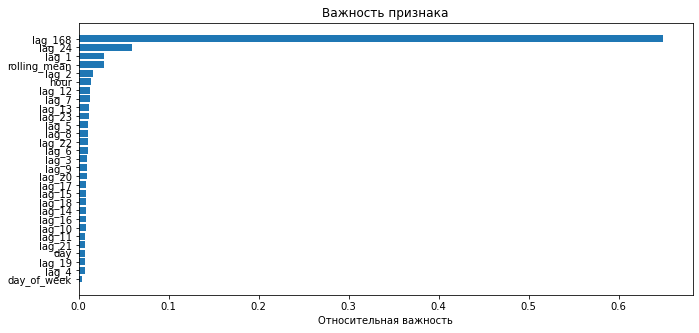

In [43]:
importances(gsearch_f, X_train)

Лучший показатель у модели Random Forrest, проведем тестирование на ней.
Также во всех моделях lag168 считается самым важным признаком.

## Тестирование

In [44]:
RMSE_forest_test = mean_squared_error(y_test, gsearch_f.best_estimator_.predict(X_test)) ** 0.5
print('Forest-RMSE на тестовой выборке', RMSE_forest_test)

Forest-RMSE на тестовой выборке 40.448140861733236


Метрика не больше 48, значит мы добились желаемого результата.

In [45]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print('RMSE для проверки модели на адекватность:', mean_squared_error(y_test, pred_previous)**0.5)

RMSE для проверки модели на адекватность: 58.881776776551476


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48